In [1]:
from Stable_SSM_EM import *
import numpy as np
import pandas as pd
from Utilities import *
from ModelTest import loadTestSets

In [2]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

## Load Feather data

In [3]:
# Info on what's available
feather_wsns = ["ktl", "grzl"]

# Choose a network
df_feather_ktl = pd.read_csv("../output/feather/%s.csv" % feather_wsns[0])
times = pd.to_datetime(df_feather_ktl["time"])

# Extract values
y_sd_raw = df_feather_ktl[["snowdepth_%i" % s for s in range(1, 12)]].values
y_t_raw = df_feather_ktl[["air_temp_%i" % s for s in range(1, 12)]].values
y_rh_raw = df_feather_ktl[["rel_humidity_%i" % s for s in range(1, 12)]].values

In [ ]:
n_LF = 2
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
max_it = 100

ti, tf = 15040, 15240
Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)
s_list = [0]

X_hat, sigma_smooth, sigma_filt, pi0, sigma0, As, Bs, Cs, Ds, Qs, Rs = ssm_em_stable(Y, U, V, ss, s_list, n_LF, max_it)

Y_hat = np.einsum("tij,jt->it", Cs[ss], X_hat) + np.einsum("tij,jt->it", Ds[ss], V)

In [10]:
n_LF = 2
sensors = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10]
max_it = 500

ti, tf = 15040, 15240
Y = y_sd_raw[ti:tf, sensors].T

# Set controls
U = np.zeros([1, tf-ti])
V = np.ones([1, tf-ti]) # should be ones

# Discrete state
ss = np.zeros(tf-ti, dtype=int)

X_hat, sigma_smooth, sigma_filt, A, B, C, D, Q, R, pi0, sigma0 = ssm_em_stable(Y, U, V, ss, n_LF, max_it)

Y_hat = np.dot(C, X_hat) + np.dot(D, V)

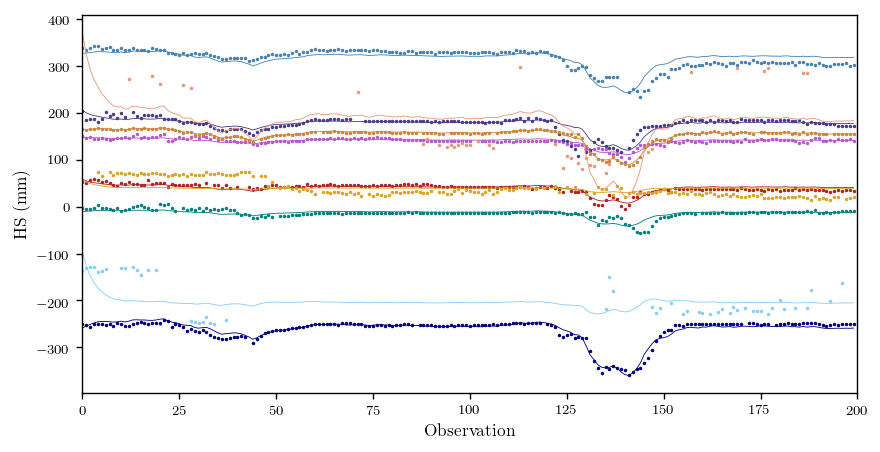

In [11]:
plt.figure(figsize=(8, 4))

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_hat[s, :], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=2.0, color=c)

plt.xlim(0, tf-ti)
plt.xlabel("Observation")
plt.ylabel("HS (mm)")

In [25]:
print A, "\n\n", C, "\n\n", D, "\n\n", R

[[ 0.95835162 -0.00928091 -0.2759973   0.20250452]
 [-0.03666593  0.97927457 -0.0826699   0.22568063]
 [ 0.0098556  -0.00264219  0.88219238 -0.00415463]
 [ 0.02512464 -0.01206315 -0.04152986  0.74505479]] 

[[ -1.97341721e+00  -1.10067141e+00   6.78284578e-02  -1.76737155e+00]
 [ -5.29493334e-01  -1.36418568e-01   1.94788080e+00  -2.17461941e+00]
 [ -9.38597447e-01   1.82738211e+00   3.22021988e-01  -4.07418664e-05]
 [ -6.50809315e-01  -1.86158087e-01   2.54733072e+00   6.36452158e-01]] 

[[ 315.89922616]
 [  40.51513536]
 [  38.9544105 ]
 [ 141.21942124]] 

[[ 4.25647155  0.          0.          0.        ]
 [ 0.          3.32233876  0.          0.        ]
 [ 0.          0.          9.10521503  0.        ]
 [ 0.          0.          0.          1.29780917]]


## Checking PCA-only result

(0, 200)

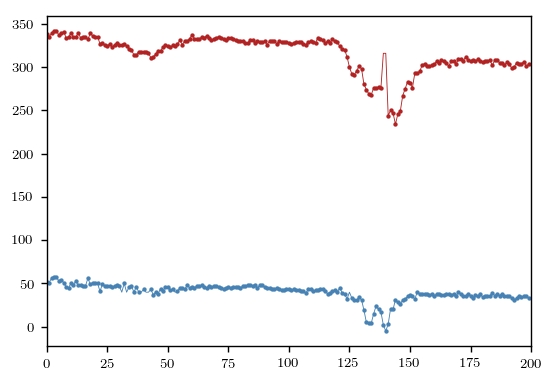

In [70]:
Y_mean = np.nanmean(Y, axis=1).reshape(-1, 1)
C, X_PCA, Y_imp = pca_est_MD(Y - Y_mean, n_LF, max_it)

for s, c in zip(range(len(sensors)), colors):
    plt.plot(Y_imp[s, :] + Y_mean[s], '-', linewidth=0.5, color=c)
    plt.plot(Y[s, :], '.', markersize=3.0, color=c)
    
plt.xlim(0, tf-ti)

In [ ]:
#ti, tf = 27005, 27500
#ti, tf = 27015, 27055 # ~ night
#ti, tf = 27065, 27105 # ~ day
ti, tf = 15005, 15205 # ~ 2 full days

plt.plot(y_sd_raw[ti:tf, :])

## Scratch work

In [ ]:
nan_sensors, nan_times = np.where(np.isnan(Y))
obs_sensors, obs_times = np.where(~np.isnan(Y))

In [ ]:
E_y = Y.copy()
E_y[nan_sensors, nan_times] = (np.dot(C, X_hat) + np.dot(D, V))[nan_sensors, nan_times]

In [ ]:
Y_residual = Y - Y_hat

In [ ]:
plt.plot(Y_residual.T)